In [1]:
import pandas as pd
import psycopg2
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import json


In [2]:
def consultar_datos(filename, db_name, table_name):
    try:
        with open(filename, 'r') as file:
            config = json.load(file)

        connection = psycopg2.connect(
            host=config["host"],
            user=config["user"],
            password=config["password"],
            dbname=db_name
        )

        query = f"SELECT * FROM {table_name}"
        water = pd.read_sql(query, connection)

        return water
    except (Exception, psycopg2.DatabaseError) as error:
        print(f"Error al consultar datos: {error}")
        return None
    finally:
        if connection:
            connection.close()

if __name__ == "__main__":
    filename = 'db_config.json'
    db_name = 'db_water'
    table_name = 'water_table'
    water = consultar_datos(filename, db_name, table_name)

    if water is not None:
        print(water.head())


C:\Users\JSLV3\AppData\Local\Temp\ipykernel_16756\3057348308.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  water = pd.read_sql(query, connection)


          Año NombreDepartamento  Div_dpto NombreMunicipio  Divi_muni  \
0  2010-01-01            Bolívar        13        El Guamo      13248   
1  2010-01-01            Bolívar        13        El Guamo      13248   
2  2010-01-01            Bolívar        13        El Guamo      13248   
3  2010-01-01            Bolívar        13        El Guamo      13248   
4  2010-01-01            Bolívar        13        El Guamo      13248   

   IrcaMinimo  IrcaMaximo  IrcaPromedio NombreParametroAnalisis2  \
0         0.0       100.0         37.32        Alcanilidad Total   
1         0.0       100.0         37.32                 Aluminio   
2         0.0       100.0         37.32                 Arsénico   
3         0.0       100.0         37.32                   Cadmio   
4         0.0       100.0         37.32                   Calcio   

   MuestrasEvaluadas  MuestrasTratadas  MuestrasSinTratar  \
0                 67                67                  0   
1                 67          

In [3]:
water.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408311 entries, 0 to 408310
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Año                       408311 non-null  object 
 1   NombreDepartamento        408311 non-null  object 
 2   Div_dpto                  408311 non-null  int64  
 3   NombreMunicipio           408311 non-null  object 
 4   Divi_muni                 408311 non-null  int64  
 5   IrcaMinimo                408311 non-null  float64
 6   IrcaMaximo                408311 non-null  float64
 7   IrcaPromedio              408311 non-null  float64
 8   NombreParametroAnalisis2  408311 non-null  object 
 9   MuestrasEvaluadas         408311 non-null  int64  
 10  MuestrasTratadas          408311 non-null  int64  
 11  MuestrasSinTratar         408311 non-null  int64  
 12  NumeroParametrosMinimo    408311 non-null  int64  
 13  NumeroParametrosMaximo    408311 non-null  i

In [4]:
water.describe()

,Div_dpto,Divi_muni,IrcaMinimo,IrcaMaximo,IrcaPromedio,MuestrasEvaluadas,MuestrasTratadas,MuestrasSinTratar,NumeroParametrosMinimo,NumeroParametrosMaximo,NumeroParametrosPromedio,ResultadoMinimo,ResultadoMaximo,ResultadoPromedio
count,408311.000000,408311.000000,408311.000000,408311.000000,408311.000000,408311.000000,408311.000000,408311.000000,408311.000000,408311.000000,408311.000000,145950.000000,1.459500e+05,145950.000000
mean,37.239367,37581.153307,2.540458,65.297188,23.729879,432.972002,340.066371,92.905631,6.285954,13.380031,9.113401,9.862479,8.427607e+02,81.500645
std,25.837315,25853.649830,11.118831,33.751641,22.257533,1254.252534,1165.921438,273.226174,3.907431,3.741823,3.576248,123.277709,5.496726e+04,2933.574927
min,5.000000,5001.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,2.000000,2.000000,-10.000000,-3.000000e-02,-0.520000
25%,15.000000,15537.000000,0.000000,36.580000,4.630000,124.000000,99.000000,0.000000,2.000000,11.000000,6.000000,0.000000,2.500000e-01,0.100000
50%,25.000000,25596.000000,0.000000,75.770000,16.820000,214.000000,162.000000,0.000000,6.000000,13.000000,9.000000,0.100000,6.800000e+00,2.350000
75%,63.000000,63548.000000,0.000000,96.840000,38.710000,408.000000,316.000000,80.000000,9.000000,16.000000,12.000000,5.000000,3.910000e+01,15.000000
max,99.000000,99773.000000,100.000000,100.000000,100.000000,38014.000000,37893.000000,5810.000000,21.000000,38.000000,21.000000,22308.000000,1.452000e+07,748085.000000


Nos asegurándonos  que las columnas categoricas estén formateados consistentemente:

In [5]:
water['NombreDepartamento'] = water['NombreDepartamento'].str.title().str.strip()
water['NombreMunicipio'] = water['NombreMunicipio'].str.title().str.strip()

water.head()


,Año,NombreDepartamento,Div_dpto,NombreMunicipio,Divi_muni,IrcaMinimo,IrcaMaximo,IrcaPromedio,NombreParametroAnalisis2,MuestrasEvaluadas,MuestrasTratadas,MuestrasSinTratar,NumeroParametrosMinimo,NumeroParametrosMaximo,NumeroParametrosPromedio,ResultadoMinimo,ResultadoMaximo,ResultadoPromedio
0,2010-01-01,Bolívar,13,El Guamo,13248,0.0,100.0,37.32,Alcanilidad Total,67,67,0,2,7,2,23.0,23.0,23.0
1,2010-01-01,Bolívar,13,El Guamo,13248,0.0,100.0,37.32,Aluminio,67,67,0,2,7,2,NaN,NaN,NaN
2,2010-01-01,Bolívar,13,El Guamo,13248,0.0,100.0,37.32,Arsénico,67,67,0,2,7,2,NaN,NaN,NaN
3,2010-01-01,Bolívar,13,El Guamo,13248,0.0,100.0,37.32,Cadmio,67,67,0,2,7,2,NaN,NaN,NaN
4,2010-01-01,Bolívar,13,El Guamo,13248,0.0,100.0,37.32,Calcio,67,67,0,2,7,2,14.0,14.0,14.0


Convertimos todos los nombres a un formato estándar  y eliminamos espacios al inicio y al final, y reduciremos los espacios múltiples a uno solo.

Analizando valores faltantes:

In [6]:
missing_values = water.isnull().sum()

missing_values = missing_values[missing_values > 0]

missing_values


ResultadoMinimo      262361
ResultadoMaximo      262361
ResultadoPromedio    262361
dtype: int64

Las columnas ResultadoMinimo, ResultadoMaximo y ResultadoPromedio tienen valores faltantes, con un total de 262,361 valores faltantes en cada una. Esto sugiere que hay muchas mediciones en las que estos resultados no se proporcionaron o no aplican.

In [7]:
missing_percentage = water[['ResultadoMinimo', 'ResultadoMaximo', 'ResultadoPromedio']].isnull().mean() * 100

print(missing_percentage)


ResultadoMinimo      64.255188
ResultadoMaximo      64.255188
ResultadoPromedio    64.255188
dtype: float64



 realizamos un análisis de la distribución de los valores existentes en ResultadoMinimo, ResultadoMaximo, y ResultadoPromedio para entender mejor estos datos:

In [8]:
descriptive_stats = water[['ResultadoMinimo', 'ResultadoMaximo', 'ResultadoPromedio']].describe()

descriptive_stats

,ResultadoMinimo,ResultadoMaximo,ResultadoPromedio
count,145950.000000,1.459500e+05,145950.000000
mean,9.862479,8.427607e+02,81.500645
std,123.277709,5.496726e+04,2933.574927
min,-10.000000,-3.000000e-02,-0.520000
25%,0.000000,2.500000e-01,0.100000
50%,0.100000,6.800000e+00,2.350000
75%,5.000000,3.910000e+01,15.000000
max,22308.000000,1.452000e+07,748085.000000


La distribución de los valores en las columnas ResultadoMinimo, ResultadoMaximo, y ResultadoPromedio muestra una amplia gama de valores, desde negativos hasta positivos muy grandes, lo que indica una variabilidad significativa en los datos

Realizaremos un análisis para ver si hay alguna correlación entre las filas con datos faltantes y otras variables. Esto nos ayudaría a entender si los datos faltantes están relacionados con otras características de los datos:

In [9]:
water['missing_values'] = water[['ResultadoMinimo', 'ResultadoMaximo', 'ResultadoPromedio']].isnull().any(axis=1)

correlation_with_missing = water.corr()['missing_values'].sort_values()

correlation_with_missing = correlation_with_missing.drop('missing_values')

plt.figure(figsize=(10, 8))
correlation_with_missing.plot(kind='bar')
plt.title('Correlación de la presencia de valores faltantes con otras columnas')
plt.xlabel('Columnas')
plt.ylabel('Correlación con valores faltantes')
plt.show()

TypeError: float() argument must be a string or a real number, not 'datetime.date'

Los resultados de la correlación muestran que no hay ninguna correlación fuerte con la presencia de valores faltantes, ya que los valores son relativamente bajos. Esto sugiere que los valores faltantes pueden no estar sistemáticamente relacionados con otras variables numéricas en nuestro dataset.

¿Existe una manera de imputar estos valores basada en otros datos disponibles?

Imputación por promedio:

In [9]:
promedio_resultado_minimo = water['ResultadoMinimo'].mean()
promedio_resultado_maximo = water['ResultadoMaximo'].mean()
promedio_resultado_promedio = water['ResultadoPromedio'].mean()

water['ResultadoMinimo'].fillna(promedio_resultado_minimo, inplace=True)
water['ResultadoMaximo'].fillna(promedio_resultado_maximo, inplace=True)
water['ResultadoPromedio'].fillna(promedio_resultado_promedio, inplace=True)

water[['ResultadoMinimo', 'ResultadoMaximo', 'ResultadoPromedio']].head(15)

C:\Users\JSLV3\AppData\Local\Temp\ipykernel_16756\2895450698.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  water['ResultadoMinimo'].fillna(promedio_resultado_minimo, inplace=True)
C:\Users\JSLV3\AppData\Local\Temp\ipykernel_16756\2895450698.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

,ResultadoMinimo,ResultadoMaximo,ResultadoPromedio
0,23.000000,23.000000,23.000000
1,9.862479,842.760662,81.500645
2,9.862479,842.760662,81.500645
3,9.862479,842.760662,81.500645
4,14.000000,14.000000,14.000000
5,9.862479,842.760662,81.500645
6,9.862479,842.760662,81.500645
7,5.200000,5.200000,5.200000
8,9.862479,842.760662,81.500645
9,0.000000,80.000000,11.230000


Al utilizar el promedio, todos los valores faltantes se reemplazan por un único valor promedio, ignorando la variabilidad esencial entre diferentes muestras y localidades. Esto resulta en una representación simplificada que puede distorsionar el análisis, especialmente en estudios donde las diferencias en los niveles de contaminación son críticas para determinar la salud pública y la seguridad ambiental. La uniformidad impuesta por el promedio elimina la capacidad de detectar variaciones importantes en la calidad del agua, llevando potencialmente a interpretaciones erróneas y decisiones inadecuadas basadas en un entendimiento incompleto de los datos.

Imputación por mediana:

In [10]:
mediana_resultado_minimo = water['ResultadoMinimo'].median()
mediana_resultado_maximo = water['ResultadoMaximo'].median()
mediana_resultado_promedio = water['ResultadoPromedio'].median()

water['ResultadoMinimo'].fillna(mediana_resultado_minimo, inplace=True)
water['ResultadoMaximo'].fillna(mediana_resultado_maximo, inplace=True)
water['ResultadoPromedio'].fillna(mediana_resultado_promedio, inplace=True)

water[['ResultadoMinimo', 'ResultadoMaximo', 'ResultadoPromedio']].head()

C:\Users\JSLV3\AppData\Local\Temp\ipykernel_16756\3587708736.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  water['ResultadoMinimo'].fillna(mediana_resultado_minimo, inplace=True)
C:\Users\JSLV3\AppData\Local\Temp\ipykernel_16756\3587708736.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

,ResultadoMinimo,ResultadoMaximo,ResultadoPromedio
0,23.000000,23.000000,23.000000
1,9.862479,842.760662,81.500645
2,9.862479,842.760662,81.500645
3,9.862479,842.760662,81.500645
4,14.000000,14.000000,14.000000


Al igual que en el caso de la imputación por promedio, la mediana asigna un único valor a todos los registros faltantes de una columna, ignorando la variabilidad y las relaciones entre variables

En el contexto de nuestro trabajo, que implica analizar la calidad del agua a través de los parámetros ResultadoMinimo, ResultadoMaximo, y ResultadoPromedio, enfrentamos desafíos significativos al imputar los valores faltantes con métodos generales como el promedio o la mediana. Estos enfoques no capturan la complejidad y la variabilidad específica de los datos relacionados con la calidad del agua, donde cada parámetro puede variar considerablemente por factores geográficos, temporales y ambientales.

Por lo tanto, en este caso específico, la eliminación de las columnas ResultadoMinimo, ResultadoMaximo, y ResultadoPromedio puede ser la decisión más prudente. Esta acción elimina el riesgo de introducir sesgos significativos a través de la imputación y nos permite enfocarnos en partes del conjunto de datos con información completa y precisa

In [11]:
water = water.drop(['ResultadoMinimo', 'ResultadoMaximo', 'ResultadoPromedio'], axis=1)

Volvemos a revisar que no se presenten mas valores faltantes:

In [12]:
water_faltantes = water.isnull().sum()


water_faltantes[water_faltantes > 0]

Series([], dtype: int64)

Investigación de filas duplicadas:

In [13]:
filas_duplicadas_antes = water.duplicated().sum()

water = water.drop_duplicates()

filas_duplicadas_despues = water.duplicated().sum()

filas_duplicadas_antes, filas_duplicadas_despues

(0, 0)

No se encontraron filas duplicadas en el dataset

 Verificación de los tipos de datos de las columnas para asegurar que coincidan con el contenido que albergan.

In [14]:
tipos_datos_actuales = water.dtypes

tipos_datos_actuales

Año                          object
NombreDepartamento           object
Div_dpto                      int64
NombreMunicipio              object
Divi_muni                     int64
IrcaMinimo                  float64
IrcaMaximo                  float64
IrcaPromedio                float64
NombreParametroAnalisis2     object
MuestrasEvaluadas             int64
MuestrasTratadas              int64
MuestrasSinTratar             int64
NumeroParametrosMinimo        int64
NumeroParametrosMaximo        int64
NumeroParametrosPromedio      int64
dtype: object

Cambio tipo de dato de "Año":

In [15]:
water['Año'] = pd.to_datetime(water['Año'], format='%Y')

water.dtypes

Año                         datetime64[ns]
NombreDepartamento                  object
Div_dpto                             int64
NombreMunicipio                     object
Divi_muni                            int64
IrcaMinimo                         float64
IrcaMaximo                         float64
IrcaPromedio                       float64
NombreParametroAnalisis2            object
MuestrasEvaluadas                    int64
MuestrasTratadas                     int64
MuestrasSinTratar                    int64
NumeroParametrosMinimo               int64
NumeroParametrosMaximo               int64
NumeroParametrosPromedio             int64
dtype: object

In [16]:
%pip install unidecode
import pandas as pd
from unidecode import unidecode

for col in water.select_dtypes(include=['object']).columns:
    water[col] = water[col].apply(lambda x: unidecode(x) if isinstance(x, str) else x)

water.head()

Note: you may need to restart the kernel to use updated packages.


,Año,NombreDepartamento,Div_dpto,NombreMunicipio,Divi_muni,IrcaMinimo,IrcaMaximo,IrcaPromedio,NombreParametroAnalisis2,MuestrasEvaluadas,MuestrasTratadas,MuestrasSinTratar,NumeroParametrosMinimo,NumeroParametrosMaximo,NumeroParametrosPromedio
0,2010-01-01,Bolivar,13,El Guamo,13248,0.0,100.0,37.32,Alcanilidad Total,67,67,0,2,7,2
1,2010-01-01,Bolivar,13,El Guamo,13248,0.0,100.0,37.32,Aluminio,67,67,0,2,7,2
2,2010-01-01,Bolivar,13,El Guamo,13248,0.0,100.0,37.32,Arsenico,67,67,0,2,7,2
3,2010-01-01,Bolivar,13,El Guamo,13248,0.0,100.0,37.32,Cadmio,67,67,0,2,7,2
4,2010-01-01,Bolivar,13,El Guamo,13248,0.0,100.0,37.32,Calcio,67,67,0,2,7,2


In [17]:
water = water.drop(columns=[ 'missing_values'])


water.head()

KeyError: "['missing_values'] not found in axis"

Valores atipicos 

In [ ]:

import pandas as pd

outliers_count = {}


numeric_cols = water.select_dtypes(include=['float64', 'int64']).columns

Q1 = water[numeric_cols].quantile(0.25)
Q3 = water[numeric_cols].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


outliers_count = ((water[numeric_cols] < limite_inferior) | (water[numeric_cols] > limite_superior)).sum()

print("Número de valores atípicos por columna:")
print(outliers_count)

Número de valores atípicos por columna:
Div_dpto                        0
Divi_muni                       0
IrcaMinimo                  32230
IrcaMaximo                      0
IrcaPromedio                 2439
MuestrasEvaluadas           43560
MuestrasTratadas            41658
MuestrasSinTratar           50383
NumeroParametrosMinimo        102
NumeroParametrosMaximo       5658
NumeroParametrosPromedio        0
dtype: int64


Iniciaremos la imputación de valores atipicos con nuestra columna de mayor importancia "IRCA PROMEDIO"

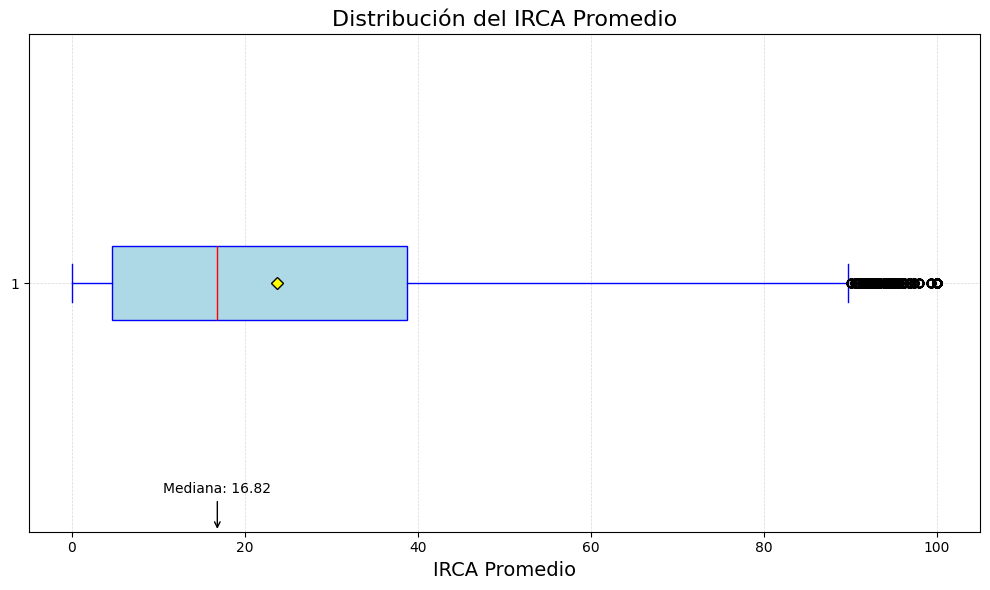

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))


bp = plt.boxplot(water['IrcaPromedio'], vert=False, patch_artist=True, showmeans=True,
                 boxprops=dict(facecolor='lightblue', color='blue'),
                 whiskerprops=dict(color='blue'),
                 capprops=dict(color='blue'),
                 medianprops=dict(color='red'),
                 meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='yellow'))


plt.title('Distribución del IRCA Promedio', fontsize=16)
plt.xlabel('IRCA Promedio', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()


median_value = np.median(water['IrcaPromedio'])
plt.annotate(f'Mediana: {median_value:.2f}', xy=(median_value, 0.5), xytext=(median_value, 0.6),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             horizontalalignment='center', verticalalignment='top')


plt.show()

que vemos en el grafico?

In [ ]:
Q1 = water['IrcaPromedio'].quantile(0.25)
Q3 = water['IrcaPromedio'].quantile(0.75)
IQR = Q3 - Q1


limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

valores_atipicos = water[(water['IrcaPromedio'] < limite_inferior) | (water['IrcaPromedio'] > limite_superior)]

muestras_atipicas_detalles = valores_atipicos[['Año', 'NombreDepartamento', 'NombreMunicipio', 'IrcaPromedio']]

print(muestras_atipicas_detalles.head())

           Año NombreDepartamento  NombreMunicipio  IrcaPromedio
306 2010-01-01            Guainia  Puerto Colombia         97.95
307 2010-01-01            Guainia  Puerto Colombia         97.95
308 2010-01-01            Guainia  Puerto Colombia         97.95
309 2010-01-01            Guainia  Puerto Colombia         97.95
310 2010-01-01            Guainia  Puerto Colombia         97.95


In [ ]:
water['EsAtipico'] = (water['IrcaPromedio'] < limite_inferior) | (water['IrcaPromedio'] > limite_superior)

valores_atipicos_por_departamento = water.groupby('NombreDepartamento')['EsAtipico'].sum()

valores_atipicos_por_departamento = valores_atipicos_por_departamento.sort_values(ascending=False)

print(valores_atipicos_por_departamento)

NombreDepartamento
Tolima                                                      509
Magdalena                                                   410
Choco                                                       375
Cauca                                                       348
Bolivar                                                     312
Antioquia                                                   159
Cesar                                                        94
Vaupes                                                       76
Guainia                                                      75
Caqueta                                                      47
Santander                                                    34
Quindio                                                       0
Risaralda                                                     0
Sucre                                                         0
Putumayo                                                      0
Norte De Santander   

In [ ]:
def obtener_valores_atipicos_por_departamento(df, departamento, limite_inferior, limite_superior):

    datos_departamento = df[df['NombreDepartamento'] == departamento]

    
    valores_atipicos = datos_departamento[
        (datos_departamento['IrcaPromedio'] < limite_inferior) |
        (datos_departamento['IrcaPromedio'] > limite_superior)
    ]

    return valores_atipicos

nombre_departamento = 'Magdalena' #Cambia el deartamento que desees observar
valores_atipicos_departamento = obtener_valores_atipicos_por_departamento(water, nombre_departamento, limite_inferior, limite_superior)


print(valores_atipicos_departamento[['NombreMunicipio', 'IrcaPromedio']])


       NombreMunicipio  IrcaPromedio
159888         Zapayan         96.07
159889         Zapayan         96.07
159890         Zapayan         96.07
159891         Zapayan         96.07
159892         Zapayan         96.07
...                ...           ...
169839       Aracataca         92.92
169840       Aracataca         92.92
169841       Aracataca         92.92
169842       Aracataca         92.92
169843       Aracataca         92.92

[410 rows x 2 columns]


explicacion de por que los vamos a dejar los atipicos

Valor atipicos de IRCA minimo

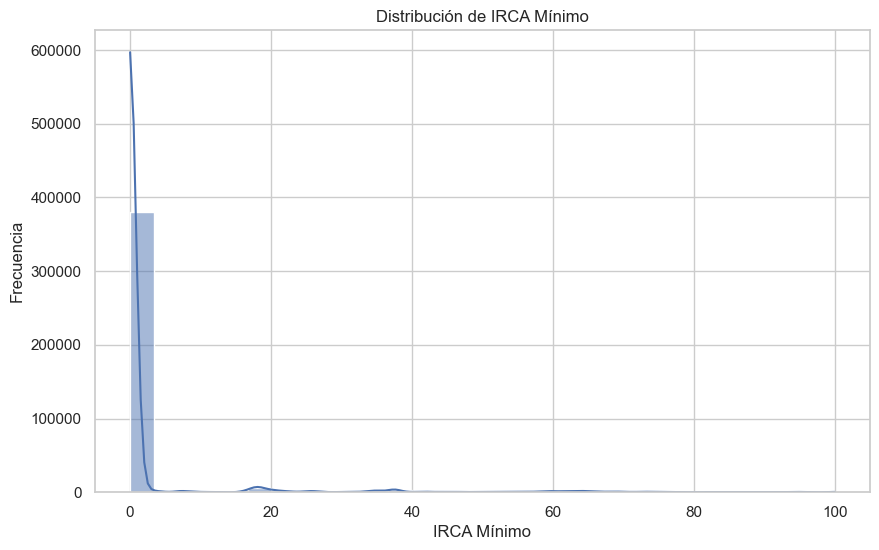

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(water['IrcaMinimo'], kde=True, bins=30)
plt.title('Distribución de IRCA Mínimo')
plt.xlabel('IRCA Mínimo')
plt.ylabel('Frecuencia')
plt.show()

La distribución de IrcaMinimo muestra una concentración de valores en un rango específico, con la presencia de una cola hacia valores más altos. Esta distribución sugiere que, aunque la mayoría de los valores son relativamente bajos (indicando un riesgo bajo a moderado de la calidad del agua), hay una cantidad significativa de valores que se extienden hacia rangos más altos, lo cual podría ser indicativo de situaciones de riesgo más elevado en ciertas áreas.

Conclusión atipicos de IRCA: Estos resultados son consistentes con el contexto práctico de los datos, donde valores más altos de IRCA minimo y promedio, indican un mayor riesgo asociado con la calidad del agua La presencia de estos valores extremos, lejos de ser errores o anomalías sin significado práctico, subraya la importancia de monitorear y mejorar la calidad del agua en áreas donde el IRCA es alto. Estos análisis resaltan la variabilidad y los desafíos en la gestión de la calidad del agua a nivel local y regional.

##Creando analisis más detallado sobre la calidad del agua en nuestros datos:


Identificamos los parámetros de análisis que tienen mayor influencia en la contaminación del agua:

In [ ]:
parametros_influencia = water.groupby('NombreParametroAnalisis2')['IrcaPromedio'].mean().sort_values(ascending=False)

top_20_parametros = parametros_influencia.head(15)

top_20_parametros

NombreParametroAnalisis2
ph                               23.941989
Cromo total                      23.941989
Olor                             23.941989
Mesofilos                        23.941989
Mercurio                         23.941989
Manganeso                        23.941989
Magnesio                         23.941989
Hierro total                     23.941989
Organofosforados y carbamatos    23.941989
Alcanilidad Total                23.941989
Fosfatos                         23.941989
Fluoruros                        23.941989
Plomo                            23.941989
E.coli                           23.941989
Dureza total                     23.941989
Name: IrcaPromedio, dtype: float64

Todos estos parámetros tienen un valor promedio de "IrcaPromedio" de aproximadamente 25, lo que sugiere una influencia significativa en la calidad del agua según este índice

In [ ]:
water = water[water['NombreParametroAnalisis2'].isin(top_20_parametros.index)]

water.head(), water.shape

(          Año NombreDepartamento  Div_dpto NombreMunicipio  Divi_muni  \
 0  2010-01-01            Bolivar        13        El Guamo      13248   
 13 2010-01-01            Bolivar        13        El Guamo      13248   
 14 2010-01-01            Bolivar        13        El Guamo      13248   
 15 2010-01-01            Bolivar        13        El Guamo      13248   
 16 2010-01-01            Bolivar        13        El Guamo      13248   
 
     IrcaMinimo  IrcaMaximo  IrcaPromedio NombreParametroAnalisis2  \
 0          0.0       100.0         37.32        Alcanilidad Total   
 13         0.0       100.0         37.32              Cromo total   
 14         0.0       100.0         37.32             Dureza total   
 15         0.0       100.0         37.32                   E.coli   
 16         0.0       100.0         37.32                Fluoruros   
 
     MuestrasEvaluadas  MuestrasTratadas  MuestrasSinTratar  \
 0                  67                67                  0   
 13   

Hemos filtrado el dataset para dejar solo las filas correspondientes a los top 20 parámetros de análisis relacionados con la contaminación del agua y los demas han salido eliminados

#Transformación de columnas:

In [ ]:
def clasificar_irca(irca):
    if irca == 0:
        return 'Sin información'
    elif 0.001 <= irca <= 5:
        return 'Sin riesgo'
    elif 5.001 <= irca <= 14:
        return 'Bajo'
    elif 19.001 <= irca <= 35:
        return 'Medio'
    elif 54.001 <= irca <= 70:
        return 'Alto'
    elif 124.001 <= irca <= 100:
        return 'Inviable'
    else:
        return 'No clasificado' 

water['rango_irca'] = water['IrcaPromedio'].apply(clasificar_irca)


In [ ]:
water['porcentaje_muestras_tratadas'] = (water['MuestrasTratadas'] / water['MuestrasEvaluadas']) * 100

water[[ 'MuestrasEvaluadas', 'MuestrasTratadas', 'porcentaje_muestras_tratadas']].head()


,MuestrasEvaluadas,MuestrasTratadas,porcentaje_muestras_tratadas
0,67,67,100.0
13,67,67,100.0
14,67,67,100.0
15,67,67,100.0
16,67,67,100.0


 "Porcentaje de Muestras Tratadas" fue generada a partir del dataset original, utilizando las columnas de Muestras Tratadas y Muestras Evaluadas para calcular el porcentaje de agua que ha sido sometida a tratamiento en diversas localidades. 

In [ ]:
water['diferencia_muestras_tratadas_sin_tratar'] = abs(water['MuestrasTratadas'] - water['MuestrasSinTratar'])

water[['MuestrasTratadas', 'MuestrasSinTratar', 'diferencia_muestras_tratadas_sin_tratar']].head()

,MuestrasTratadas,MuestrasSinTratar,diferencia_muestras_tratadas_sin_tratar
0,67,0,67
13,67,0,67
14,67,0,67
15,67,0,67
16,67,0,67


La columna "Diferencia entre Muestras Tratadas y Sin Tratar" fue desarrollada para cuantificar la brecha en el número de muestras de agua que han sido sometidas a tratamiento en comparación con aquellas que no lo han sido dentro de cada conjunto de datos evaluados

In [ ]:
water['rango_parametros_analizados'] = water['NumeroParametrosMaximo'] - water['NumeroParametrosMinimo']

water[[ 'NumeroParametrosMinimo', 'NumeroParametrosMaximo', 'rango_parametros_analizados']].head()

,NumeroParametrosMinimo,NumeroParametrosMaximo,rango_parametros_analizados
0,2,7,5
13,2,7,5
14,2,7,5
15,2,7,5
16,2,7,5


La columna "Rango de Parámetros Analizados" fue creada para proporcionar una medida de la variabilidad en el análisis de calidad del agua, reflejando la diferencia entre el número máximo y mínimo de parámetros químicos y biológicos examinados en cada muestra.

In [ ]:
columnas_a_eliminar = ['MuestrasTratadas', 'MuestrasEvaluadas', 'MuestrasSinTratar',
                      'NumeroParametrosMinimo', 'NumeroParametrosMaximo', 'EsAtipico']
water = water.drop(columns=columnas_a_eliminar)


water.head()

KeyError: "['MuestrasTratadas', 'MuestrasEvaluadas', 'MuestrasSinTratar', 'NumeroParametrosMinimo', 'NumeroParametrosMaximo', 'EsAtipico'] not found in axis"

In [ ]:
water.columns = water.columns.str.replace(' ', '_').str.lower()

# Imprimimos el DataFrame modificado para ver el resultado
water.head()

,año,nombredepartamento,div_dpto,nombremunicipio,divi_muni,ircaminimo,ircamaximo,ircapromedio,nombreparametroanalisis2,numeroparametrospromedio,esatipico,rango_irca,porcentaje_muestras_tratadas,diferencia_muestras_tratadas_sin_tratar,rango_parametros_analizados
0,2010-01-01,Bolivar,13,El Guamo,13248,0.0,100.0,37.32,Alcanilidad Total,2,False,No clasificado,100.0,67,5
13,2010-01-01,Bolivar,13,El Guamo,13248,0.0,100.0,37.32,Cromo total,2,False,No clasificado,100.0,67,5
14,2010-01-01,Bolivar,13,El Guamo,13248,0.0,100.0,37.32,Dureza total,2,False,No clasificado,100.0,67,5
15,2010-01-01,Bolivar,13,El Guamo,13248,0.0,100.0,37.32,E.coli,2,False,No clasificado,100.0,67,5
16,2010-01-01,Bolivar,13,El Guamo,13248,0.0,100.0,37.32,Fluoruros,2,False,No clasificado,100.0,67,5


Exportamos el nuevo archivo con el procesamiento y transformaciones:

In [ ]:
water.to_csv('water_cleaned.csv', index=False)